In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re

from scipy.optimize import curve_fit
from scipy import special

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Latin Modern Roman"],  # must be installed on your system
    "mathtext.fontset": "cm",             # Computer Modern math, matches LaTeX style
    "text.usetex": True,                    # render text via LaTeX
    "text.latex.preamble": r"\usepackage{amsmath, amssymb}"
})

In [20]:
from readTLMData import TLMREADER
folder_path = r"K:\tech_stud\Hager_Lutz\cTLM_Testprozess\IV\final_TLM_2"


TLMREADER(folder_path)        
list_of_measurements = TLMREADER(folder_path).readTLMData()
list_of_measurements = dict(sorted(list_of_measurements.items()))

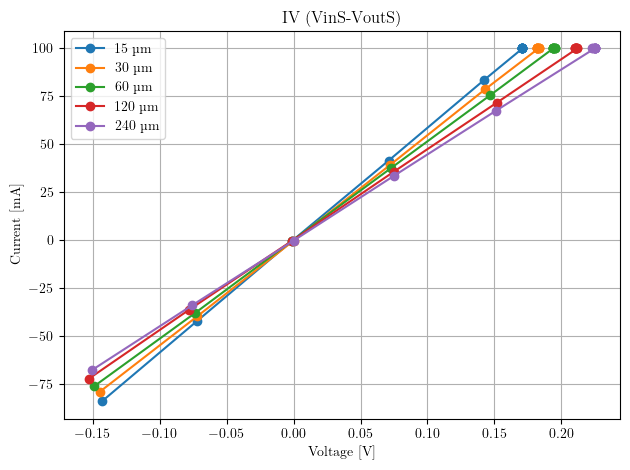

In [21]:
# plt.figure(figsize=(8, 5))
plt.figure()

for key in list_of_measurements.keys():
    # plt.plot(list_of_measurements[key]['Vin'], list_of_measurements[key]['Iin']*1000, label=key)
    plt.plot(list_of_measurements[key]['delta_V'], list_of_measurements[key]['Iin']*1000, 'o-', label=f"{key} µm")

plt.xlabel("Voltage [V]")
plt.ylabel("Current [mA]")
# plt.xlim(-0.5, 0.5)
plt.title('IV (VinS-VoutS)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
# plt.savefig(os.path.join(folder_path, 'IV.png'), bbox_inches='tight')

In [22]:
def get_resistance(list_of_measurements):
    R_list = []
    for key in list_of_measurements.keys():
        slope, intercept = np.polyfit(list_of_measurements[key]['delta_V'], list_of_measurements[key]['Iin'], 1)
        R_list.append((1/slope))  # in ohm

    return R_list


def get_lin_fit(x, y):
    slope, intercept = np.polyfit(x, y, 1)
    y_fit = slope * x + intercept
    r_squared = 1- np.sum((y - y_fit)**2)/(np.sum((y - np.mean(y))**2)) # R^2 = 1 - SS_res / SS_tot = 1 - (y-y_fit)^2/(y-mean(y))^2

    return slope, intercept, r_squared

def get_tlm_params(slope, intercept, Z):
    R_sh = slope * Z   # in Ohm/sq
    R_C = intercept / 2 # in Ohm
    
    L_T = intercept / (slope * 2)
    # simple rho_c calculation
    roh_C = (R_sh * (L_T) ** 2) * 1e-8  # 1e-8 to convert from ohm·μm² to ohm·cm²
    
    return R_sh, R_C, L_T, roh_C


def sci_notation_latex(x, precision=2):
    mantissa, exp = f"{x:.{precision}e}".split("e")
    return rf"{mantissa} \cdot 10^{{{int(exp)}}}"

[ 15  30  60 120 240]
R^2 = 0.8875896802434748


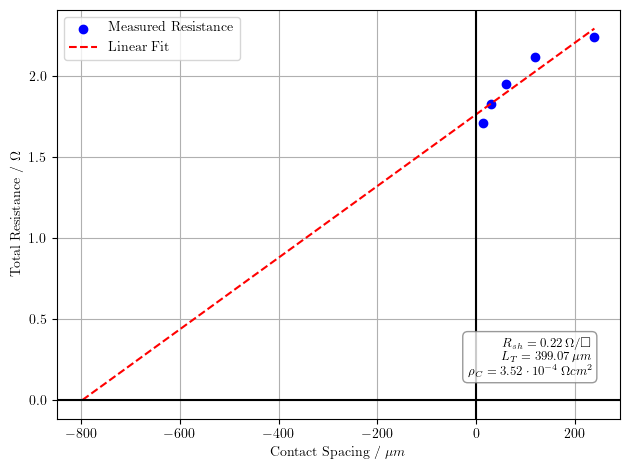

In [ ]:
plt.figure()

distances = list(map(int, list_of_measurements.keys()))
distances = np.array(distances)
print(distances)

R_list = get_resistance(list_of_measurements)  

plt.scatter(distances, R_list, color='blue', marker='o', label='Measured Resistance')

slope, intercept, r_squared = get_lin_fit(distances, R_list)
print(f'R^2 = {r_squared}')
R_sh, R_C, L_T, roh_C = get_tlm_params(slope, intercept, Z=100)

x_fit_extended = np.linspace(-intercept/slope, distances.max(), 200) # extend x-axis for better visualization
plt.plot(x_fit_extended, (slope * x_fit_extended + intercept), 'r--', label='Linear Fit')


tlm_text = (
    f"$R_{{sh}} = {R_sh:.2f} \\, \\Omega / \\square$\n"
    f"$L_T = {L_T:.2f} \\, \\mu m$\n"
    f"$\\rho_C = {sci_notation_latex(roh_C)} \\, \\Omega cm^2$" # {roh_C:.2e}   {sci_notation_latex(roh_C)}
)

plt.gca().text(
    0.95, 0.1, tlm_text,
    fontsize=9,
    transform=plt.gca().transAxes,
    verticalalignment='bottom',
    horizontalalignment='right',
    bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8, edgecolor='gray')
)

plt.axhline(0, color='black', linewidth=1.5)
plt.axvline(0, color='black', linewidth=1.5)

plt.xlabel("Contact Spacing / $\\mu m$")
plt.ylabel("Total Resistance / $\\Omega$")
plt.legend()
plt.tight_layout()
plt.grid(True)
# plt.savefig('../Images/IV/cTLM_Ni_TLM_2.pdf', dpi=500)
plt.show()